## Black Box Approach for 2 genres classification - Hip Hop vs Classical

We aim at training a Neural Network to distinguish between two genres: Hip Hop and classical.

In [1]:
#importing google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
#setting the working directory
%cd /gdrive/MyDrive/polimi/NAML/NAML_proj/

/gdrive/MyDrive/polimi/NAML/NAML_proj


In [3]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os
import random
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import librosa
import os

tfk = tf.keras
tfkl = tf.keras.layers
seed = 42

The dataset is composed of Mel-Spectrograms of each audio sample, labeled with respect to each genre

In [6]:
dataset = []
#genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
genres = {'hiphop': 0, 'classical': 1}
n_genres = 2

for genre, genre_number in genres.items():
    for filename in os.listdir(f'dataset_old/genres/{genre}'):
        songname = f'dataset_old/genres/{genre}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=29.7)
        ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 256, n_fft = 512)
        ps = librosa.power_to_db(ps**2)
        dataset.append( (ps, genre_number) )
    print(str(genre+' done'))

hiphop done
classical done


We split the dataset according to the following composition:


*   70% training set
*   20% validation set
*   10% test set

Maintaining equal proportions amongst classes



In [7]:
order = np.arange(start = 0, stop = 100, step = 1)

np.random.seed(seed)

training = []
validation = []
test = []

for i in range(n_genres):
  shuffle = np.random.permutation(order)
  for k in range(70):
    training.append(dataset[i*100 + shuffle[k]])
  for l in range(20):
    validation.append(dataset[i*100 + shuffle[l+70]])
  for m in range(10):
    test.append(dataset[i*100 + shuffle[m+90]])

In [8]:
X_train, Y_train = zip(*training)
X_valid, Y_valid = zip(*validation)
X_test, Y_test = zip(*test)

X_train = np.array([x.reshape( (128, 2559, 1) ) for x in X_train])
X_valid = np.array([x.reshape( (128, 2559, 1) ) for x in X_valid])
X_test = np.array([x.reshape( (128, 2559, 1) ) for x in X_test])

Y_train = np.array(tfk.utils.to_categorical(Y_train, 2))
Y_valid = np.array(tfk.utils.to_categorical(Y_valid, 2))
Y_test = np.array(tfk.utils.to_categorical(Y_test, 2))

The proposed model is composed as a stack of convolutional layer, followed by a Global Average Pooling layer leading to a fully connected section.

Optimization is performed as a Batch version of Adam optimizer algorithm

In [21]:
def build_model(input_shape, n_units):
# Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        name = 'conv_1',
        filters=4,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    conv1_2 = tfkl.Conv2D(
        name = 'conv_1_2',
        filters=8,
        kernel_size=(2, 2),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv1)
    pool1 = tfkl.MaxPooling2D(
        name = 'pool_1',
        pool_size = (2, 2)
    )(conv1_2)

    conv2 = tfkl.Conv2D(
        name = 'conv_2',
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        name = 'pool_2',
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        name = 'conv_3',
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        name = 'pool_3',
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        name = 'conv_4',
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    conv4_2 = tfkl.Conv2D(
        name = 'conv_4_2',
        filters=64,
        kernel_size=(2, 2),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv4)
    pool4 = tfkl.MaxPooling2D(
        name = 'pool_4',
        pool_size = (2, 2)
    )(conv4_2)

    conv5 = tfkl.Conv2D(
        name = 'conv_5',
        filters=128,
        kernel_size=(2, 2),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        name = 'pool_5',
        pool_size = (2, 2)
    )(conv5)

    conv6 = tfkl.Conv2D(
        name = 'conv_6',
        filters=286,
        kernel_size=(1, 1),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool5)
    

    global_average = tfkl.GlobalAveragePooling2D(name = 'GAP')(conv6)
    global_average = tfkl.Dropout(0.3,name = 'Dropout_GAP', seed=seed)(global_average)
    
    classifier_layer = tfkl.Dense(units=64, name='Classifier', activation='relu')(global_average)
    
    classifier_layer = tfkl.Dropout(0.3, seed=seed, name = 'Dropout_Classifier')(classifier_layer)
    classifier_layer_2 = tfkl.Dense(units=32, name='Classifier_2', activation='relu')(classifier_layer)
    classifier_layer_2 = tfkl.Dropout(0.25, seed=seed, name = 'Dropout_Classifier_2')(classifier_layer_2)
    output_layer = tfkl.Dense(units=n_units, activation='softmax', name='Output')(classifier_layer_2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model

    return model

In [22]:
input_shape = (128, 2559, 1)

model = build_model(input_shape, n_genres)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 2559, 1)]    0         
                                                                 
 conv_1 (Conv2D)             (None, 128, 2559, 4)      40        
                                                                 
 conv_1_2 (Conv2D)           (None, 128, 2559, 8)      136       
                                                                 
 pool_1 (MaxPooling2D)       (None, 64, 1279, 8)       0         
                                                                 
 conv_2 (Conv2D)             (None, 64, 1279, 16)      1168      
                                                                 
 pool_2 (MaxPooling2D)       (None, 32, 639, 16)       0         
                                                                 
 conv_3 (Conv2D)             (None, 32, 639, 32)       4640  

In [16]:
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)
adaptive_LR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-4)

standard_history = model.fit(
    x = X_train,
    y = Y_train,
    epochs = 500,
    batch_size = 20,
    validation_data= (X_valid, Y_valid),
    callbacks = [early_stopping, adaptive_LR]
    )

Epoch 1/500
7/7 [==============================] - 2s 191ms/step - loss: 0.7323 - accuracy: 0.6000 - val_loss: 0.6001 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/500
7/7 [==============================] - 1s 123ms/step - loss: 0.6147 - accuracy: 0.7071 - val_loss: 0.4249 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 3/500
7/7 [==============================] - 1s 135ms/step - loss: 0.3965 - accuracy: 0.8643 - val_loss: 0.1697 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 4/500
7/7 [==============================] - 1s 121ms/step - loss: 0.3086 - accuracy: 0.8857 - val_loss: 0.0693 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 5/500
7/7 [==============================] - 1s 122ms/step - loss: 0.1794 - accuracy: 0.9357 - val_loss: 0.0318 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/500
7/7 [==============================] - 1s 121ms/step - loss: 0.1531 - accuracy: 0.9500 - val_loss: 0.0502 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 7/500
7/7 [==============================] - 1s 131ms/step - loss: 0.1

Accuracy: 0.95
Precision: 0.9545
Recall: 0.95
F1: 0.9499


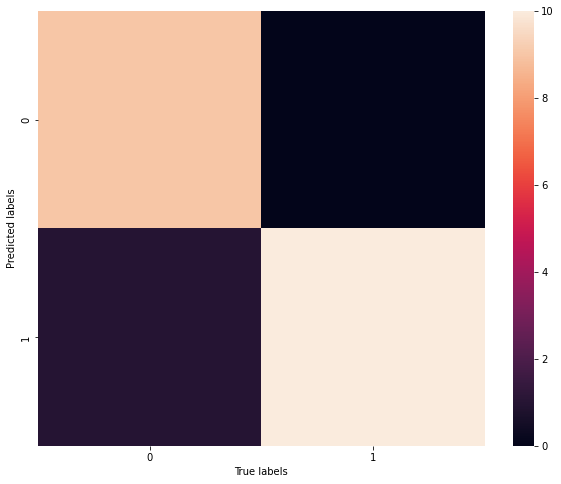

In [18]:
predictions = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T)#, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [13]:
model.save('/gdrive/MyDrive/polimi/NAML/NAML_proj/models/hiphopvclassical/hiphopvclassical')

INFO:tensorflow:Assets written to: /gdrive/MyDrive/polimi/NAML/NAML_proj/models/hiphopvclassical/hiphopvclassical/assets


INFO:tensorflow:Assets written to: /gdrive/MyDrive/polimi/NAML/NAML_proj/models/hiphopvclassical/hiphopvclassical/assets
